# Tobig's 정규세션 10주차 음성 과제 1

- 다음 5개의 질문에 **단답형**으로 답해주세요.

## Q1. 시간에 따른 소리의 진폭을 나타낸 그래프를 영어로 무엇이라고 하나요?

A1. Waveform

## Q2. 샘플링 주파수는 원래 신호의 최고 주파수의 2배 이상이 되어야 원래 신호로 복구할 수 있다는 정리의 이름을 영어로 무엇이라고 하나요?

A2. Nyquist-Shannon Sampling Theorem

## Q3. 소리를 시각화한 것으로, 단시간 푸리에 변환을 통해 시간, 주파수, 진폭 정보를 모두 담고 있는 것을 영어로 무엇이라고 하나요?

A3. Spectrogram

## Q4. 인간의 청각 시스템에 맞게 Mel-scale을 적용하여 주파수를 조절한 스펙트로그램을 영어로 무엇이라고 하나요?

A4. Mel-Spectrogram

## Q5. Speech 정규세션 강의자가 수업 시작할 때 5명을 랜덤으로 지목하여 질문하겠다고 했으나, 실제로는 그보다 적은 n명에게 질문하였습니다. n의 값은 무엇입니까?

A5. 0

# Tobig's 정규세션 10주차 음성 과제 2

1. train 폴더 내의 2,000개 음원을 이용하여 음성 분류 모델을 만들어보세요.
2. 음성 분류 모델을 이용하여 test 폴더 내의 300개 음원을 분류하세요.

In [75]:
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import noisereduce as nr
import IPython as ipd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

## Load files and Brief EDA

In [76]:
# train 폴더 경로 설정
train_dir = 'train'

audio_data_list = []
label_list = []

# train 폴더 내의 wav 파일들을 읽어와서 저장
for file_name in tqdm(os.listdir(train_dir), desc='Loading WAV files'):
    file_path = os.path.join(train_dir, file_name)

    data, sr = librosa.load(file_path, sr=16000)

    audio_data_list.append((data, sr))

    label = int(file_name[-5])
    label_list.append(label)

Loading WAV files: 100%|██████████| 2000/2000 [00:04<00:00, 471.61it/s]


01530.wav


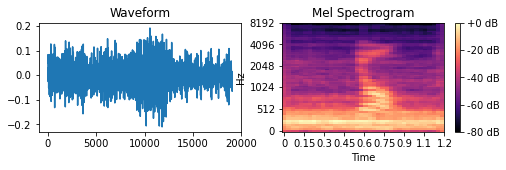

01911.wav


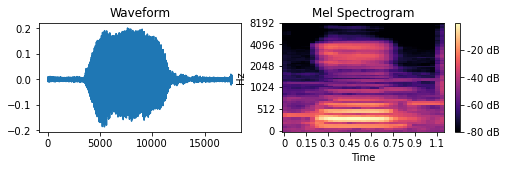

00802.wav


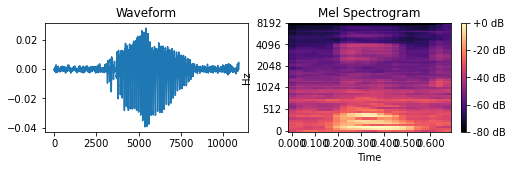

00913.wav


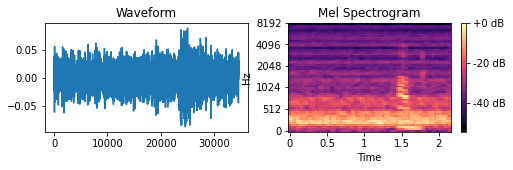

00814.wav


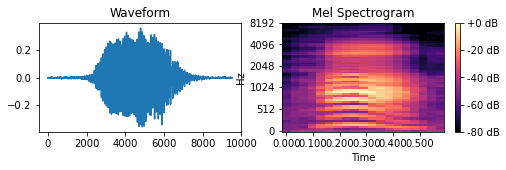

01835.wav


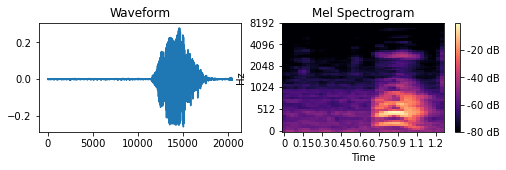

00136.wav


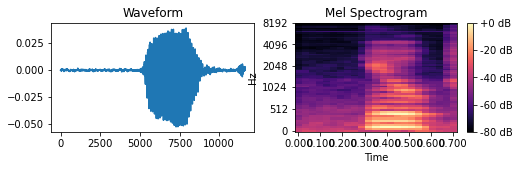

00767.wav


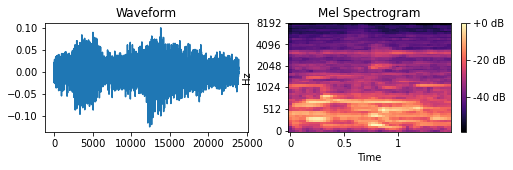

01618.wav


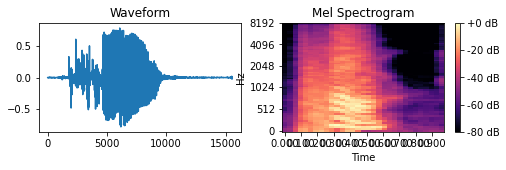

00719.wav


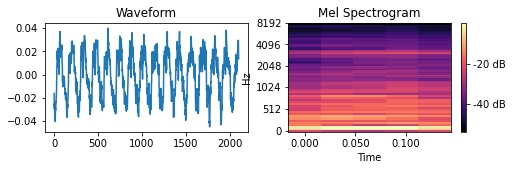

In [77]:
def visualize_with_audio(data_info):
    data, sr = data_info
    ipd.display.display(ipd.display.Audio(data=data, rate=sr))

    plt.figure(figsize=(8,2))

    plt.subplot(121)
    plt.plot(data)
    plt.title('Waveform')

    plt.subplot(122)
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=2048, hop_length=512, n_mels=64)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    plt.show()


# 랜덤으로 10개의 train set 내 음원을 추출하여 시각화 및 음원 재생

np.random.seed(11)

random_file_num = np.random.randint(0, 200, 10)
random_file_name = [str(num).zfill(4) for num in random_file_num]

for label, name in zip(range(10), random_file_name):
    n = name + str(label)
    print(str(n)+'.wav')
    data_info = audio_data_list[int(n)]
    visualize_with_audio(data_info)

시각화 및 음원을 통해 확인한 결과, 데이터에 다양한 종류의 잡음들이 섞여 있음을 알 수 있음. 

## Preprocessing

In [78]:
def preprocess_audio(audio_data_list):
    max_len = max([len(arr[0]) for arr in audio_data_list])
    mel_list = []
    mfcc_list = []

    for audio_data in tqdm(audio_data_list, desc='Making a Dataset'):
        data, sr = audio_data
        
        data = nr.reduce_noise(y=data, sr=sr, thresh_n_mult_nonstationary=10, stationary=False)
        data = librosa.util.fix_length(data, size=max_len)
        mel = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=1024, hop_length=512, n_mels=64)
        mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20, n_fft=1024, hop_length=512)
        
        mel = librosa.power_to_db(mel, ref=np.max)
        mel = (mel - mel.mean()) / mel.std()
        mfcc = (mfcc - mfcc.mean()) / mfcc.std()

        mel_list.append(mel)
        mfcc_list.append(mfcc)

    return mel_list, mfcc_list

mel_list, mfcc_list = preprocess_audio(audio_data_list)
df = pd.DataFrame({'mel': mel_list, 'mfcc': mfcc_list, 'label': label_list})

Making a Dataset: 100%|██████████| 2000/2000 [01:21<00:00, 24.57it/s]


In [79]:
class SpeechDataset(Dataset):
    def __init__(self, df):
        self.mels = df['mel']
        self.mfccs = df['mfcc']
        self.labels = df['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mel = self.mels[idx]
        mfcc = self.mfccs[idx]
        label = self.labels[idx]
        melspec_tensor = torch.from_numpy(mel).float()
        mfcc_tensor = torch.from_numpy(mfcc).float()
        label_tensor = torch.tensor(label)
        return melspec_tensor, mfcc_tensor, label_tensor

## Modeling

In [80]:
class SpeechClassificationModel(nn.Module):
    def __init__(self, num_classes, weights):
        super(SpeechClassificationModel, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.mel_fc = nn.Linear(512 * 6, 128)
        self.mfcc_fc = nn.Linear(128 * 14, 128)
        self.final_relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        self.weights = torch.tensor(weights)

    def forward(self, melspec, mfcc):
        x1 = melspec.unsqueeze(1)
        x1 = self.convblock1(x1)
        x1 = self.convblock2(x1)
        x1 = self.convblock3(x1)
        x1 = self.convblock4(x1)
        x1 = self.convblock5(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.mel_fc(x1)
        x1 = self.final_relu(x1)
        x1 = self.fc2(x1)

        x2 = mfcc.unsqueeze(1)
        x2 = self.convblock1(x2)
        x2 = self.convblock2(x2)
        x2 = self.convblock3(x2)
        x2 = self.convblock4(x2)
        x2 = x2.view(x2.size(0), -1)
        x2 = self.mfcc_fc(x2)
        x2 = self.final_relu(x2)
        x2 = self.fc2(x2)


        return x1 * self.weights[0] + x2 * self.weights[1]

In [81]:
class ModelTrainer():
    def __init__(self, model, parameters):
        self.model = model
        self.epochs = parameters['epoch']
        self.optimizer = optim.AdamW(model.parameters(), lr=parameters['learning_rate'])
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=parameters['gamma'])
        self.early_stopping_patience = parameters['early_stopping_patience']
        self.early_stopping_counter = 0
        self.best_val_loss = float('inf')

    def train(self, train_loader, val_loader):
        for epoch in tqdm(range(self.epochs), desc='Training'):
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for melspec, mfcc, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(melspec, mfcc)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            self.scheduler.step()
            train_loss /= len(train_loader)
            train_accuracy = 100 * train_correct / train_total

            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for melspec, mfcc, labels in val_loader:
                    outputs = self.model(melspec, mfcc)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100 * val_correct / val_total

            print(f"Epoch [{epoch+1}/{self.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            # Early Stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stopping_counter = 0
            else:
                self.early_stopping_counter += 1

            if self.early_stopping_counter >= self.early_stopping_patience:
                print(f"Early stopping triggered. Best validation loss: {self.best_val_loss:.4f}")
                break

    def test(self, test_loader):
        with torch.no_grad():
            for melspec, mfcc, _ in test_loader:
                outputs = self.model(melspec, mfcc)
                _, predicted = torch.max(outputs.data, 1)
                for pred in predicted:
                    print(pred.item(), end=' ')

In [82]:
params = {'epoch': 100,
          'learning_rate': 0.001,
          'batch_size': 32,
          'weights': [1,1],
          'gamma': 0.2,
          'seed': 42,
          'early_stopping_patience':5}

## Training & Testing

In [83]:
def seed_everything(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(params['seed'])

In [84]:
# 데이터 준비
X = df[['mel','mfcc']]
y = df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, shuffle=True, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

train_dataset = SpeechDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'])
val_dataset = SpeechDataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])

model = SpeechClassificationModel(num_classes=10, weights=params['weights'])

trainer = ModelTrainer(model, params)

In [85]:
trainer.train(train_loader, val_loader)

Training:   1%|          | 1/100 [00:27<44:45, 27.13s/it]

Epoch [1/100], Train Loss: 2.3460, Train Accuracy: 9.67%, Val Loss: 2.3065, Val Accuracy: 10.00%


Training:   2%|▏         | 2/100 [01:02<52:23, 32.08s/it]

Epoch [2/100], Train Loss: 2.1478, Train Accuracy: 17.28%, Val Loss: 2.1875, Val Accuracy: 26.50%


Training:   3%|▎         | 3/100 [01:36<53:30, 33.10s/it]

Epoch [3/100], Train Loss: 1.5134, Train Accuracy: 39.94%, Val Loss: 1.9029, Val Accuracy: 43.00%


Training:   4%|▍         | 4/100 [02:08<52:05, 32.55s/it]

Epoch [4/100], Train Loss: 1.1395, Train Accuracy: 56.00%, Val Loss: 1.7485, Val Accuracy: 55.00%


Training:   5%|▌         | 5/100 [02:39<50:44, 32.05s/it]

Epoch [5/100], Train Loss: 0.8767, Train Accuracy: 68.72%, Val Loss: 1.6344, Val Accuracy: 59.00%


Training:   6%|▌         | 6/100 [03:11<50:02, 31.95s/it]

Epoch [6/100], Train Loss: 0.7394, Train Accuracy: 73.00%, Val Loss: 1.5258, Val Accuracy: 77.00%


Training:   7%|▋         | 7/100 [03:42<48:47, 31.48s/it]

Epoch [7/100], Train Loss: 0.5707, Train Accuracy: 80.06%, Val Loss: 1.4358, Val Accuracy: 78.00%


Training:   8%|▊         | 8/100 [04:12<47:53, 31.23s/it]

Epoch [8/100], Train Loss: 0.5198, Train Accuracy: 79.83%, Val Loss: 1.5014, Val Accuracy: 77.50%


Training:   9%|▉         | 9/100 [04:43<47:10, 31.11s/it]

Epoch [9/100], Train Loss: 0.4513, Train Accuracy: 83.67%, Val Loss: 1.3966, Val Accuracy: 75.50%


Training:  10%|█         | 10/100 [05:16<47:22, 31.58s/it]

Epoch [10/100], Train Loss: 0.3787, Train Accuracy: 86.11%, Val Loss: 1.2048, Val Accuracy: 85.50%


Training:  11%|█         | 11/100 [05:52<48:59, 33.03s/it]

Epoch [11/100], Train Loss: 0.3811, Train Accuracy: 86.44%, Val Loss: 1.3297, Val Accuracy: 83.50%


Training:  12%|█▏        | 12/100 [06:29<50:04, 34.14s/it]

Epoch [12/100], Train Loss: 0.3627, Train Accuracy: 86.44%, Val Loss: 1.0902, Val Accuracy: 87.50%


Training:  13%|█▎        | 13/100 [07:07<51:10, 35.29s/it]

Epoch [13/100], Train Loss: 0.3306, Train Accuracy: 88.67%, Val Loss: 1.2001, Val Accuracy: 87.00%


Training:  14%|█▍        | 14/100 [07:49<53:38, 37.43s/it]

Epoch [14/100], Train Loss: 0.3124, Train Accuracy: 89.17%, Val Loss: 0.9346, Val Accuracy: 88.50%


Training:  15%|█▌        | 15/100 [08:32<55:18, 39.04s/it]

Epoch [15/100], Train Loss: 0.2702, Train Accuracy: 89.89%, Val Loss: 0.9575, Val Accuracy: 87.50%


Training:  16%|█▌        | 16/100 [11:01<1:41:07, 72.23s/it]

Epoch [16/100], Train Loss: 0.2842, Train Accuracy: 89.72%, Val Loss: 1.0296, Val Accuracy: 87.00%


Training:  17%|█▋        | 17/100 [13:07<2:02:16, 88.39s/it]

Epoch [17/100], Train Loss: 0.2712, Train Accuracy: 90.78%, Val Loss: 1.0473, Val Accuracy: 86.50%


Training:  17%|█▋        | 17/100 [15:30<1:15:42, 54.73s/it]


KeyboardInterrupt: 

In [ ]:
test_dir = 'test'
test_audio_data_list = []

for file_name in tqdm(os.listdir(test_dir), desc='Loading WAV files'):
    file_path = os.path.join(test_dir, file_name)

    data, sr = librosa.load(file_path, sr=16000)

    test_audio_data_list.append((data, sr))

d, r = test_audio_data_list[-1]
d = librosa.util.fix_length(d, size=max([len(arr[0]) for arr in audio_data_list]))
test_audio_data_list[-1] = (d,r)

test_mel_list, test_mfcc_list = preprocess_audio(test_audio_data_list)
test_df = pd.DataFrame({'mel': test_mel_list, 'mfcc': test_mfcc_list, 'label': [0 for _ in range(len(test_mfcc_list))]})

test_dataset = SpeechDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=len(test_df))

Making a Dataset: 100%|██████████| 300/300 [00:11<00:00, 26.71it/s]


In [ ]:
trainer.test(test_loader)

7 1 8 2 8 1 8 2 8 4 5 9 0 4 5 2 3 5 3 6 0 2 8 7 4 7 1 3 5 2 6 6 2 4 9 7 7 5 7 2 4 7 0 9 3 6 9 9 9 5 9 5 7 4 9 6 6 9 6 7 6 2 7 7 2 4 0 7 6 6 3 0 3 5 3 5 4 7 5 9 4 5 7 1 3 8 2 1 7 8 9 2 9 1 6 6 4 2 7 4 2 7 4 6 6 4 9 1 9 3 2 6 6 3 0 5 9 9 2 2 3 6 7 4 6 3 5 6 6 6 2 4 0 3 4 9 7 2 4 0 5 3 3 4 2 9 5 2 6 9 5 9 5 6 3 0 7 3 8 1 3 2 7 2 8 6 2 7 9 4 6 7 7 6 7 6 7 2 6 9 8 2 3 8 8 0 7 9 3 1 9 5 2 5 1 0 1 9 0 1 1 5 7 3 8 3 4 1 8 7 9 3 0 7 0 2 1 5 4 0 8 5 1 4 9 9 3 4 8 8 4 1 6 7 5 0 9 2 3 4 7 6 1 4 6 0 6 2 8 0 8 2 7 6 4 8 9 0 6 6 8 4 7 9 9 6 7 8 6 9 7 4 2 3 0 5 4 4 5 4 4 7 2 0 7 5 4 5 0 5 2 9 9 4 4 2 2 9 6 2 